# Homework 2 - Data Science with CO2

__Hand-in__:

- __Due: 07.04.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Description of the project:

   In this assignment, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city zones and the **zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements. 

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements on temperature and humidity.


### To start with: 

The following csv files will be needed which can be found in the `../data/` folder: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
3. `sensor_metadata_updated.csv`

   __Description__: It contains the name of the site (LocationName), the zone index (zone), the altitude in meters, and longitude, latitude. 

Import the following python packages:

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import array
import os
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

### PART I: Handling time series with pandas (10 points)

a) **8/10** Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe like this:

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |

The merged dataframe contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, the humidity, the zone, the altitude, the longitude and the latitude. For each measurement, take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [2]:
# First, let's load the data :
co2 = pd.read_csv("../data/CO2_sensor_measurements.csv", sep="\t")
temp_hum = pd.read_csv("../data/temperature_humidity.csv", sep="\t")
metadata = pd.read_csv("../data/sensors_metadata_updated.csv")

In [3]:
# Now take a look at the data
co2.head(1)

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562


In [4]:
co2.dtypes

timestamp         object
LocationName      object
SensorUnit_ID      int64
CO2              float64
dtype: object

In [5]:
temp_hum.head(1)

,Timestamp,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
0,2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,...,10.13,96.828979,10.5,95.858139,10.7,94.524902,11.35,90.288681,11.44,90.118927


In [6]:
temp_hum.dtypes

Timestamp            object
1014.temperature    float64
1014.humidity       float64
1015.temperature    float64
1015.humidity       float64
                     ...   
1297.humidity       float64
1298.temperature    float64
1298.humidity       float64
1299.temperature    float64
1299.humidity       float64
Length: 93, dtype: object

In [7]:
metadata.head(1)

,Unnamed: 0,LocationName,zone,altitude,LAT,LON,X,Y
0,0,AJGR,2,627.8,47.33321,8.4803,243005.0,678731.4


In [8]:
metadata = metadata.drop(columns=["Unnamed: 0", "X", "Y"]).rename(columns={"LAT":"lat", "LON":"lon"})
metadata.dtypes

LocationName     object
zone              int64
altitude        float64
lat             float64
lon             float64
dtype: object

To use some useful pandas methods and to merge the dataframe, we will rename some columns and convert the type of timestamp to datatime :

In [9]:
co2 = co2.rename(columns={"timestamp":"Timestamp"})
co2["Timestamp"] = pd.to_datetime(co2.Timestamp)
temp_hum["Timestamp"] = pd.to_datetime(temp_hum.Timestamp)

Then, we will use the suggested functions to merge the dataframes and create the desired result :

In [10]:
# First check missing values :
co2.isnull().sum()

Timestamp        0
LocationName     0
SensorUnit_ID    0
CO2              0
dtype: int64

In [11]:
temp_hum.isnull().sum()

Timestamp             0
1014.temperature    473
1014.humidity       473
1015.temperature    270
1015.humidity       270
                   ... 
1297.humidity        10
1298.temperature    552
1298.humidity       552
1299.temperature     46
1299.humidity        46
Length: 93, dtype: int64

In [12]:
# There are missing values in temp_hum -> Let's interpolate them linearly
temp_hum = temp_hum.interpolate(method="linear")
temp_hum.isnull().sum() 

Timestamp           0
1014.temperature    0
1014.humidity       0
1015.temperature    0
1015.humidity       0
                   ..
1297.humidity       0
1298.temperature    0
1298.humidity       0
1299.temperature    0
1299.humidity       0
Length: 93, dtype: int64

In [13]:
# Resampling : 
co2_df = co2.groupby(["LocationName", "SensorUnit_ID"]).resample("30T", on="Timestamp").mean().drop(columns=["SensorUnit_ID"])\
            .reset_index().set_index(["Timestamp", "SensorUnit_ID"]).interpolate(method="linear")
co2_df.head(5)

# Note that we had to interpolate here as the resampling added null values 
# when there was nothing to average during some 30 min timeslots

,,LocationName,CO2
Timestamp,SensorUnit_ID,,
2017-10-01 00:00:00,1122,AJGR,340.231893
2017-10-01 00:30:00,1122,AJGR,341.213293
2017-10-01 01:00:00,1122,AJGR,338.625034
2017-10-01 01:30:00,1122,AJGR,342.874127
2017-10-01 02:00:00,1122,AJGR,345.171710


Now that the co2 and metadata dataframes are ready, we need to deal with temp_hum :

In [14]:
temp_hum = temp_hum.resample("30T", on="Timestamp").mean()
temp_hum.head(2)

,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,1018.humidity,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,11.396667,92.440806,10.513333,92.204295,11.040000,92.959605,11.04,89.914205,11.370000,91.059886,...,10.130000,97.310903,10.460000,95.701736,10.560000,94.513458,11.343333,90.577962,11.436667,89.886230
2017-10-01 00:30:00,11.303333,91.625097,10.576667,92.773956,10.996667,92.644257,10.96,89.787048,11.273333,89.996857,...,10.116667,97.788694,10.456667,96.094014,10.463333,95.242065,11.290000,90.549988,11.326667,88.851176


In [15]:
# First get the temperature and humidity columns names to isolate them and then melt to get a single row for each SensorUnit_ID
cols = list(temp_hum.columns)
temps = [x for x in cols if "temperature" in x]
hums = [x for x in cols if x not in temps]

In [16]:
temp_df = temp_hum[temps].reset_index().melt(id_vars=["Timestamp"], var_name="SensorUnit_ID", value_name="temperature")
hum_df = temp_hum[hums].reset_index().melt(id_vars=["Timestamp"], var_name="SensorUnit_ID", value_name="humidity")
temp_df["SensorUnit_ID"] = temp_df["SensorUnit_ID"].map(lambda x: int(x[:4])) # keep only the ID number
hum_df["SensorUnit_ID"] = hum_df["SensorUnit_ID"].map(lambda x: int(x[:4])) # keep only the ID number
temp_df = temp_df.set_index(["Timestamp", "SensorUnit_ID"])
hum_df = hum_df.set_index(["Timestamp", "SensorUnit_ID"])
temp_hum_df = temp_df.join(hum_df)

In [17]:
temp_hum_df.head(3)

,,temperature,humidity
Timestamp,SensorUnit_ID,,
2017-10-01 00:00:00,1014,11.396667,92.440806
2017-10-01 00:30:00,1014,11.303333,91.625097
2017-10-01 01:00:00,1014,11.240000,91.096761


Now that all the dataframes are ready, we just need to join them together to get the final dataframe:

In [18]:
curated_data = co2_df.join(temp_hum_df).reset_index().merge(metadata, on="LocationName")\
                     .sort_values(["SensorUnit_ID", "Timestamp"]).reset_index()\
                     [["Timestamp", "LocationName", "SensorUnit_ID", "CO2", "temperature",\
                      "humidity", "zone", "altitude", "lon", "lat"]]
curated_data = curated_data.set_index('Timestamp')
curated_data.head(5)

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,lon,lat
Timestamp,,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,2,413.5,8.523256,47.370446
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,2,413.5,8.523256,47.370446
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,2,413.5,8.523256,47.370446
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,2,413.5,8.523256,47.370446
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,2,413.5,8.523256,47.370446


In [19]:
curated_data.isnull().sum()

LocationName     0
SensorUnit_ID    0
CO2              0
temperature      0
humidity         0
zone             0
altitude         0
lon              0
lat              0
dtype: int64

b) **2/10** Export the curated and ready to use timeseries to a csv file. 

In [20]:
curated_data.to_csv("../data/curated_data.csv")

### PART II: Data visualization (15 points)

a) **5/15** Group the sites based on their altitude, by performing K-means clustering. Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Write out the formula of metric you intend to use for Elbow curve. Add an additional column to the dataframe of the previous question indicating the altitude cluster index. 

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [21]:
location_alt = metadata[["LocationName","altitude"]]

In [22]:
location_alt.head()

,LocationName,altitude
0,AJGR,627.8
1,BSCR,462.3
2,BUDF,490.2
3,KBRL,510.5
4,KTGM,530.3


In [23]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

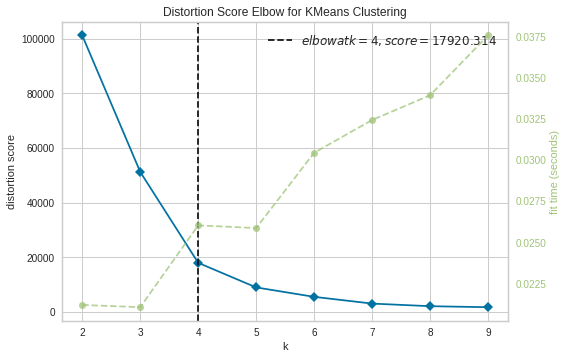

In [24]:
#Data to cluster (altitudes)
X = np.array(location_alt['altitude'])

# Instantiating the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X.reshape(-1,1))    # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

**We see that the "Elbow" value is k=4, so we can say that the optimal number of clusters is 4.**

In [25]:
kmeans = KMeans(n_clusters=4)
curated_data['cluster'] = kmeans.fit_predict(curated_data[['altitude']])

In [ ]:
curated_data

b) **3/15** Plot the monthly median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName), and give the same color to stations that belong to the same altitude  cluster.    

In [ ]:
plt.figure(figsize=(20, 15))

# we sort by location name to keep the good ordering of the data accross the different columns

co2_medians = curated_data.groupby(curated_data['LocationName'])[['CO2']].median().sort_values(by=['LocationName'])
altitude = curated_data[['LocationName', 'altitude']].drop_duplicates().set_index(['LocationName']).sort_values(by=['LocationName'])
names = np.array(curated_data[['LocationName']].drop_duplicates().sort_values(by=['LocationName']).reset_index().drop(columns=['Timestamp']))
colors = np.array(curated_data[['LocationName','cluster']].drop_duplicates().set_index(['LocationName']).sort_values(by=['LocationName']))


plt.scatter(altitude, co2_medians, s=50, cmap='Dark2' , c=colors)
for i, txt in enumerate(names):
    plt.annotate(txt, (altitude.iloc[i], co2_medians.iloc[i]))
plt.ylabel("co2 median measurements")
plt.xlabel("altitude of sensor")
plt.show()

c) **7/15** Plot the stations on an interactive Zurich map, and dispay their location name. And, on the same map, plot a time-varying heatmap of the mean daily CO2 concentration for all the stations.

__Note__: You can use the python library [Folium](https://python-visualization.github.io/folium/) for that, but any other visualization tools can be used.

In [ ]:
locations = curated_data[['LocationName', 'lat','lon']].drop_duplicates()

In [ ]:
mean_daily_co2 = curated_data.reset_index().groupby(["LocationName", "lat", "lon"]).resample("D", on="Timestamp").mean()["CO2"].reset_index().set_index("Timestamp")

In [ ]:
from sklearn import preprocessing
#we're scaling the CO2 weights to [0,1] so we can use HeatMapWithTime
x = mean_daily_co2['CO2'].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
mean_daily_co2['CO2'] = x_scaled

In [ ]:
heat_time_data = []
for date in mean_daily_co2.index.drop_duplicates():
    heat_time_data.append(mean_daily_co2.loc[date,['lat','lon','CO2']].values.tolist()) #CO2 levels on day date on all the locations

In [ ]:
from datetime import datetime, timedelta
#  Create time inidices from 1st october to the 31st for the heatmap indices
time_index = [
    (mean_daily_co2.index[0].to_pydatetime() + k * timedelta(1)).strftime('%Y-%m-%d')
    for k in range(31)
]

In [ ]:
import folium
from folium.plugins import HeatMap, HeatMapWithTime

zh_map = folium.Map(location=[47.37, 8.5233], zoom_start=12)

sensors_info = np.array(locations.reset_index().drop(columns=['Timestamp']))
# Plot it on the map
for i, info in enumerate(sensors_info):
    folium.Marker(
        location=[info[1], info[2]],
        popup=info[0],
        icon=folium.Icon(color='red', icon='info-sign')).add_to(zh_map)

HeatMapWithTime(data=heat_time_data, index = time_index, auto_play=True, radius=25, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(zh_map)

zh_map

### PART III: Model fitting for data curation (35 points)

a) __3/35__ How to handle missing data matters in real-world data science project. Although here we have all the data, it is still a very good opportunity for you to learn. Let's assume there is one site `KBRL` which somehow lost all the CO2 data of `2017-10-04`. Compare different ways of interpolating for the missing values (in time: linear interpolation and cubic interpolation, in space: using other sensors in the same altitude cluster) and plot the interpolation results. Use the data you have as the ground truth to discuss your findings.

In [ ]:
# First create the erroneous dataframe, containing None values : 
curated_data_err = curated_data.copy().reset_index()
curated_data_err["Timestamp"] = curated_data_err["Timestamp"].map(lambda x: str(x)) #remap datetime to string for simpler slicing
curated_data_err.loc[pd.Series(curated_data_err.LocationName == "KBRL") & \
                     curated_data_err.Timestamp.map(lambda x: ("2017-10-04" in x)), "CO2"] = None
curated_data_err.loc[pd.Series(curated_data_err.LocationName == "KBRL") & \
                     curated_data_err.Timestamp.map(lambda x: ("2017-10-04" in x))].head(5)

In [ ]:
# Function which returns the desired rows (2017-10-04 and KBRL) given a dataframe
def getDFa(df):
    return df.loc[pd.Series(df.LocationName == "KBRL") & \
                     df.Timestamp.map(lambda x: ("2017-10-04" in x)), ["Timestamp", "CO2"]]\
                       .sort_values(by="Timestamp").copy().set_index("Timestamp")

In [ ]:
# Time:
time_sorted = curated_data_err.sort_values(by="Timestamp")
time_linear_int = getDFa(time_sorted.interpolate(method="linear")) # time: linear
time_cubic_int = getDFa(time_sorted.interpolate(method="cubic")) #time: cubic

In [ ]:
# Space:
space_sorted = curated_data_err.sort_values(by="altitude")
space_linear_int = getDFa(space_sorted.interpolate(method="linear")) #space: linear

In [ ]:
# Ground truth:
curated_data_str = curated_data.reset_index()
curated_data_str["Timestamp"] = curated_data_str["Timestamp"].map(lambda x: str(x))
ground_truth = getDFa(curated_data_str)

Let's compare the results of these interpolations with the ground truth and discuss the results : 

In [40]:
time = pd.to_datetime(ground_truth.reset_index()['Timestamp'])
ground_truth = ground_truth.set_index(time)
time_cubic_int = time_cubic_int.set_index(time)
time_linear_int = time_linear_int.set_index(time)
space_linear_int = space_linear_int.set_index(time)

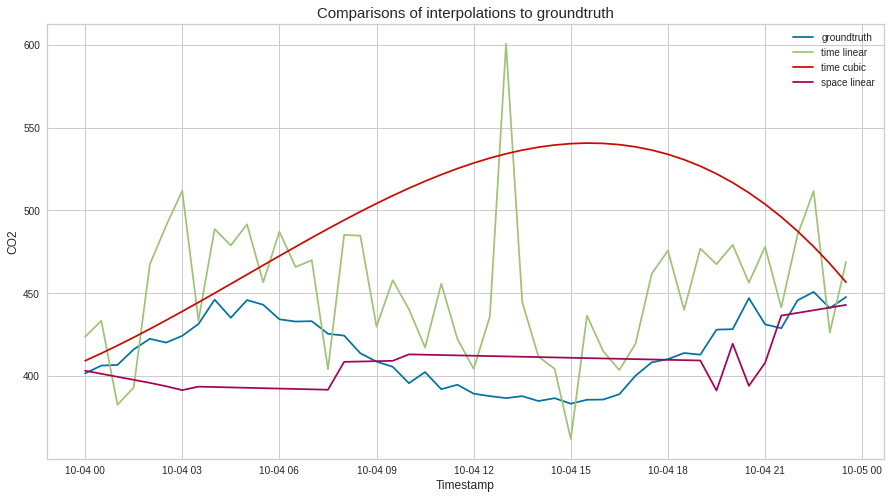

In [41]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Timestamp', fontsize = 12)
ax.set_ylabel('CO2', fontsize = 12)
ax.set_title('Comparisons of interpolations to groundtruth', fontsize = 15)

ax.plot(ground_truth)
ax.plot(time_linear_int)
ax.plot(time_cubic_int)
ax.plot(space_linear_int)

ax.legend(labels=["groundtruth", "time linear", "time cubic", "space linear"])
plt.show()

Above we get the CO2 values, interpolated in different ways and the ground truth, for the location KBLR on the 2017-10-04. The time (x axis) goes from 00h00 to 24h00 on date day. Looking at this plot, it clearly seems that the space linear interpolation is the most adequate solution, as it is the most precise on average. Also, it doesn't compute absurdly high and oscillating values as time linear does. Cubic is smoother, but the values are entirely different from the ground truth (and increase when the ground truth decrease). 

b) **2/35** The technician in charge of these sensors reported that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 21. Verify the drift by visualizing the CO2 concentration of the drifting sensor and some other sensors from the network. 

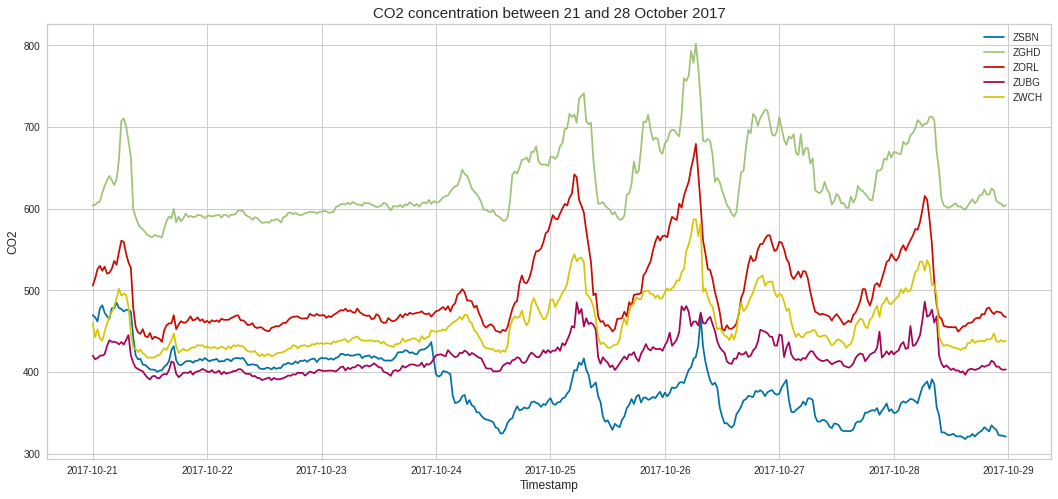

In [42]:
# Get the values from 21 to 28 october and then based on that, get the values for different locations/sensors
oct21_28 = curated_data_str[(curated_data_str["Timestamp"] > "2017-10-21") & (curated_data_str["Timestamp"] < "2017-10-29")]
ZSBN = oct21_28[oct21_28["LocationName"] == "ZSBN"][["Timestamp", "CO2"]].sort_values(by="Timestamp").set_index("Timestamp")
ZGHD = oct21_28[oct21_28["LocationName"] == "ZGHD"][["Timestamp", "CO2"]].sort_values(by="Timestamp").set_index("Timestamp")
ZORL = oct21_28[oct21_28["LocationName"] == "ZORL"][["Timestamp", "CO2"]].sort_values(by="Timestamp").set_index("Timestamp")
ZUBG = oct21_28[oct21_28["LocationName"] == "ZUBG"][["Timestamp", "CO2"]].sort_values(by="Timestamp").set_index("Timestamp")
ZWCH = oct21_28[oct21_28["LocationName"] == "ZWCH"][["Timestamp", "CO2"]].sort_values(by="Timestamp").set_index("Timestamp")

time = pd.to_datetime(oct21_28['Timestamp'].drop_duplicates())
ZSBN = ZSBN.set_index(time)
ZGHD = ZGHD.set_index(time)
ZORL = ZORL.set_index(time)
ZUBG = ZUBG.set_index(time)
ZWCH = ZWCH.set_index(time)

# Then plot the results: 
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Timestamp', fontsize = 12)
ax.set_ylabel('CO2', fontsize = 12)
ax.set_title('CO2 concentration between 21 and 28 October 2017', fontsize = 15)
ax.plot(ZSBN)
ax.plot(ZGHD)
ax.plot(ZORL)
ax.plot(ZUBG)
ax.plot(ZWCH)
ax.legend(labels=["ZSBN", "ZGHD", "ZORL", "ZUBG", "ZWCH"])

**When plotting sensors data from october 21st to october 28th, we see that the sensor located on ZSBN is recording similar differences in values as the other sensors. However, these values clearly start drifting by the 24th before having once again the same patterns as the others but shifted down a bit.**

c) **6/35** We want to reconstruct the CO2 concentration of the drifting sensor had the drift not happened. Train a forecasting model on the CO2 values of the drifting sensor. Use linear regression with features the past CO2 values over an interval of 3 hours (past 6 observations), mathematically, $C_t \sim h(C_{t-1}, C_{t-2}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6})$, where $C_i$ is the CO2 value at time $i$.

Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. What do you observe? 

__Note__: 
1. Cross validation on time series is different from that on other kinds of datasets. scikit-learn provides a nice method for you, `sklearn.model_selection.TimeSeriesSplit`. For more on time series cross validation, there are a lot of interesting articles available online.
2. Think about how to make prediction on data before the drift and after the drift. What's the difference?

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product

In [44]:
X = curated_data_str[curated_data_str["LocationName"] == "ZSBN"].reset_index()

def linear_regression(X,features,delay=6,n_splits=3,limit_date="2017-10-21", mode = 0):
    
    tscv = sklearn.model_selection.TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
    model = LinearRegression()
    n = len(features)
    error = []
    
    for train_index, test_index in tscv.split(X[(X["Timestamp"] < limit_date)][:-delay]):
        X_train = np.zeros([len(train_index),n*(delay+mode)])
        X_test = np.zeros([len(test_index),n*(delay+mode)])
        
        for i in train_index:
            X_train[i] = X[features][i:i+delay+mode].values.reshape(-1)
        
        X_test = X[features].values[test_index]
        y_train, y_test = X['CO2'][train_index+delay].values, X['CO2'][test_index+delay].values
        
        model.fit(X_train,y_train)
        y_forecast = forecast(model,X_test,len(features),delay=delay,mode=mode)
        error_tmp = mean_squared_error(y_test[delay:], y_forecast)
        print(" Mean Square Error = {} ".format(error_tmp))
        error.append(error_tmp)
    
    
    y_forecast = forecast(model, X[features].values,len(features),delay=delay,mode=mode)
    y_actual = X['CO2'][delay:]
    
    time = X['Timestamp'][delay:].drop_duplicates()
        
    return model, np.array(y_forecast).flatten() , y_actual, time , np.sqrt(np.std(error))

In [45]:
def forecast(model,X,n,delay=6,mode=0):
    X_tmp = X.copy()
    y_forecast = []
    if mode == 0:
        y_tmp = X_tmp[:,0][delay]
    for i in range(X_tmp.shape[0]-delay):
        if mode == 0:
            X_tmp[:,0][i+delay] = y_tmp
        X_pred = X_tmp[i:i+delay+mode].reshape(-1)
        y_tmp = model.predict(X_pred.reshape(1,n*(delay+mode)))
        y_forecast.append(y_tmp)
    return y_forecast

 Mean Square Error = 2671.106546996589 
 Mean Square Error = 1803.2711187949535 
 Mean Square Error = 8697.32607023579 


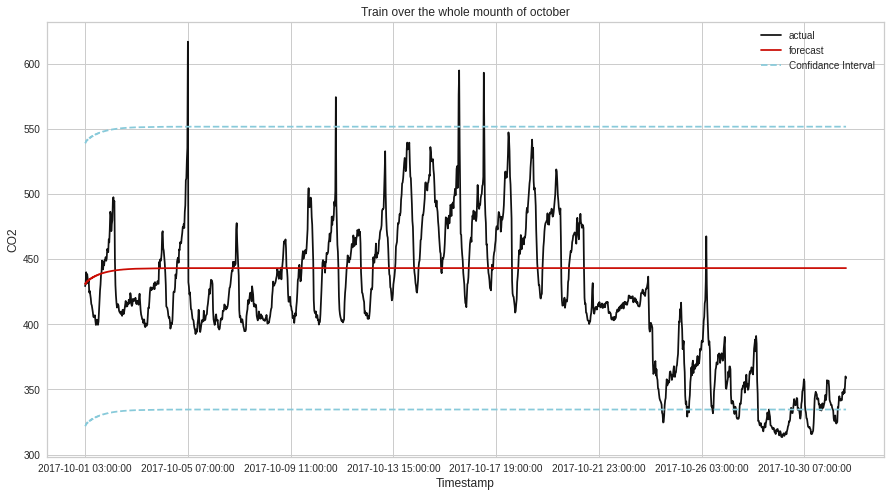

In [46]:
model, y_forecast , y_actual, time ,conf_inter = linear_regression(X,['CO2'],limit_date="2017-10-32",mode=0)
y_act = pd.DataFrame(y_actual.values,time.values)
y_act.columns = ['CO2']
y_for = pd.DataFrame(y_forecast,time.values)
y_for.columns = ['CO2']

ax = y_act.plot(figsize = (15,8),c='k')
ax.plot(y_for, c='r')
ax.plot(y_for + 1.96*conf_inter,'--', c ='c')
ax.plot(y_for - 1.96*conf_inter,'--', c ='c')
ax.set_xlabel('Timestamp', fontsize = 12)
ax.set_ylabel('CO2', fontsize = 12)
ax.legend(labels=["actual","forecast", "Confidance Interval"])
ax.set_title('Train over the whole mounth of october')
plt.show()

 Mean Square Error = 577.0544520948602 
 Mean Square Error = 2653.9262367281394 
 Mean Square Error = 1834.4401569095614 


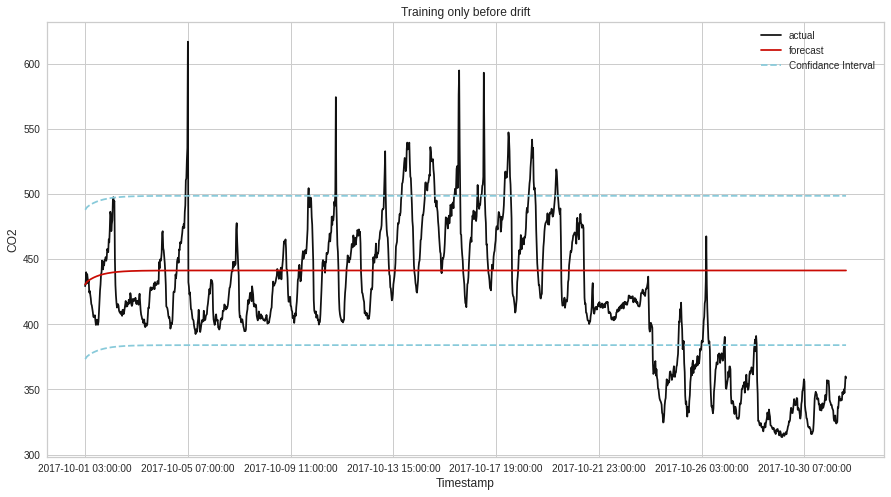

In [47]:
model, y_forecast , y_actual, time ,conf_inter = linear_regression(X,['CO2'],mode=0)
y_act = pd.DataFrame(y_actual.values,time.values)
y_act.columns = ['CO2']
y_for = pd.DataFrame(y_forecast,time.values)
y_for.columns = ['CO2']

ax = y_act.plot(figsize = (15,8),c='k')
ax.plot(y_for, c='r')
ax.plot(y_for + 1.96*conf_inter,'--', c ='c')
ax.plot(y_for - 1.96*conf_inter,'--', c ='c')
ax.set_xlabel('Timestamp', fontsize = 12)
ax.set_ylabel('CO2', fontsize = 12)
ax.legend(labels=["actual","forecast", "Confidance Interval"])
ax.set_title('Training only before drift')
plt.show()

First, we notice that our simple model is nothing but a linear regression over the data. It's not strange that it settles around the mean. 
Now if we train over the whole month of october, we will also capture the data of the drift which is not really what we want. We decided then to compare the model if we train only before the drift. We can quickly see that our prediction better follows the mean of a healthy signal and the confidence interval is smaller.
This led us to conclude that in practice, our model can quickly notice a drift but is not able to correctly follow it.

d) **3/35** Train a second forecasting model on the CO2 values of the drifting sensor. In this step, use __current__ values of temperature and humidity as features,  as well as their __past__ values over the same interval of three hours, mathematically, $C_t \sim h(T_{t}, \cdots, T_{t-6}, H_{t}, \cdots, H_{t - 6})$, where $T_i$ and $H_i$ are temperature and humidity at time $i$. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. Are you able to remove the drift? If yes, how, if no, why?

In [94]:
model, y_forecast , y_actual, time , conf_inter = linear_regression(X,['temperature','humidity'],mode=1)

 Mean Square Error = 875.2882028933625 
 Mean Square Error = 2283.4030560137967 
 Mean Square Error = 1877.9538078001588 


In [95]:
y_act = pd.DataFrame(y_actual.values,time.values)
y_act.columns = ['CO2']
y_for = pd.DataFrame(y_forecast,time.values)
y_for.columns = ['CO2']

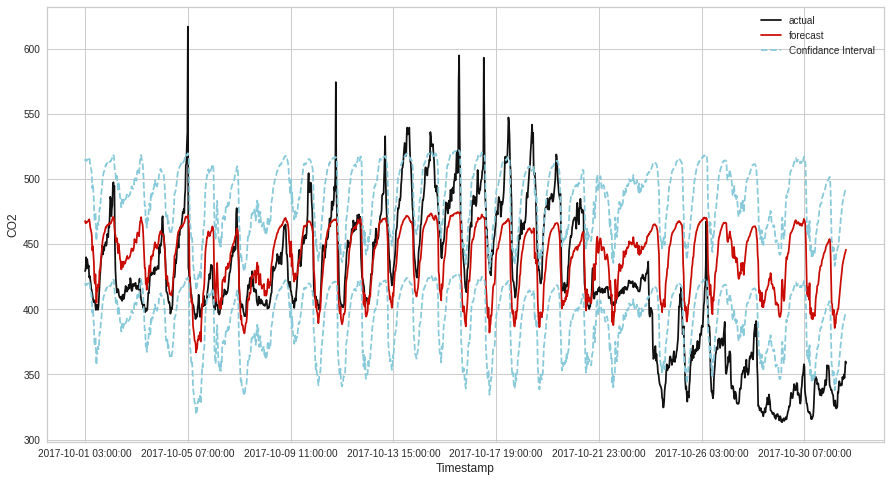

In [96]:
ax = y_act.plot(figsize = (15,8),c='k')
ax.plot(y_for, c='r')
ax.plot(y_for + 1.96*conf_inter,'--', c ='c')
ax.plot(y_for - 1.96*conf_inter,'--', c ='c')
ax.set_xlabel('Timestamp', fontsize = 12)
ax.set_ylabel('CO2', fontsize = 12)
ax.legend(labels=["actual","forecast", "Confidance Interval"])
plt.show()

Our model was able to capture the drift and is still carying most of the information from the signal. This can be explained by the amount of CO2 is mostly carried by the ambient temperature (less dense air means less concentration of gas such as CO2)and humidity. The rest is just a constant.

e) **6/35** Build another linear regression model by exploting the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar. Apply the learned model to the drifting sensor, and plot the results. Discuss your findings.

Learn a model on other sensors: $ C_t^{S} \sim h(T_{t}^{S}, \cdots, T_{t - 6}^{S}, H_{t}^{S}, \cdots, H_{t - 6}^{S})$, where $S$ is the cluster of sensors experiencing similar conditions like ZSBN.

Apply the model on ZSBN to see if the drift has been removed: $\hat{C}_t^{ZSBN} = h(T_{t}^{ZSBN}, \cdots, T_{t - 6}^{ZSBN}, H_{t}^{ZSBN}, \cdots, H_{t - 6}^{ZSBN})$


In [62]:
"""
This is a helper function that finds the closest k (5 by default) sensors locations with the same weather conditions as ZSBN
"""

def select_k_closest_regions(df, k=5):
   
    weather_conditions = df[['LocationName', 'humidity', 'temperature', 'CO2', 'altitude']]
    weather_conditions = weather_conditions.groupby(by='LocationName').mean()
    weather_conditions.reset_index(inplace=True)
    ZSBN_mean = weather_conditions[weather_conditions['LocationName'] =='ZSBN']
    weather_conditions['humidity'] = weather_conditions['humidity'] - float(ZSBN_mean['humidity'])
    weather_conditions['temperature'] = weather_conditions['temperature'] - float(ZSBN_mean['temperature'])
    weather_conditions['CO2'] = weather_conditions['CO2'] - float(ZSBN_mean['CO2'])
    weather_conditions['altitude'] = weather_conditions['altitude'] - float(ZSBN_mean['altitude'])
    weather_conditions['error'] = weather_conditions['humidity']**2 + weather_conditions['temperature']**2 + weather_conditions['CO2']**2 + weather_conditions['altitude']**2
    weather_conditions.sort_values(by=['error'], inplace=True)
    #     Use 1 to k+1 cause the first one is obviously ZSBN
    return weather_conditions[['LocationName', 'error']][1:k + 1]

In [63]:
cluster = select_k_closest_regions(curated_data, k=10)

**let's use regions that have error < 1000 ==> k = 5**

In [64]:
closest_regions = list(select_k_closest_regions(curated_data, k=5)['LocationName'])
closest_regions

['ZLDW', 'ZPFW', 'ZECB', 'WSUM', 'ZSTA']

In [65]:
X_features = pd.DataFrame(curated_data[curated_data['LocationName'] == 'ZSBN'].index).set_index('Timestamp')
targets = curated_data[curated_data['LocationName'] == 'ZSBN'][['CO2']]
for location in closest_regions:
    if (location != 'ZPFW'):
        #     We checked before hand that the whole data (from october 1st to 31st)
        data_tomerge = curated_data[curated_data['LocationName'] == location][['temperature','humidity']]
        X_features = pd.merge(X_features, data_tomerge, left_index = True, right_index = True)

X_features.head()

,temperature_x,humidity_x,temperature_y,humidity_y,temperature_x,humidity_x,temperature_y,humidity_y
Timestamp,,,,,,,,
2017-10-01 00:00:00,11.436667,89.886230,11.126667,93.349340,10.493333,94.313187,12.146667,83.361827
2017-10-01 00:30:00,11.326667,88.851176,11.086667,92.880768,10.520000,94.903829,12.041667,82.633219
2017-10-01 01:00:00,11.263333,88.593048,10.986667,92.176320,10.370000,94.351969,12.013333,82.107427
2017-10-01 01:30:00,11.300000,89.286051,10.910000,92.189354,10.253333,94.121180,11.975000,82.754654
2017-10-01 02:00:00,11.290000,89.628738,10.880000,92.123550,10.206667,94.250244,12.000000,82.955561


In [66]:
columns = ['x' + str(i) for i in range(len(X_features.columns))]
X_features.columns = columns
X_features = pd.merge(targets, X_features, left_index = True, right_index = True)

In [67]:
model, y_forecast , y_actual, time , conf_inter = linear_regression(X_features.reset_index(),list(X_features.columns[1:]),mode=1)

 Mean Square Error = 903.4455139848518 
 Mean Square Error = 2211.626417508247 
 Mean Square Error = 1501.520102088974 


In [68]:
y_act = pd.DataFrame(y_actual.values,time.values)
y_act.columns = ['CO2']
y_for = pd.DataFrame(y_forecast,time.values)
y_for.columns = ['CO2']

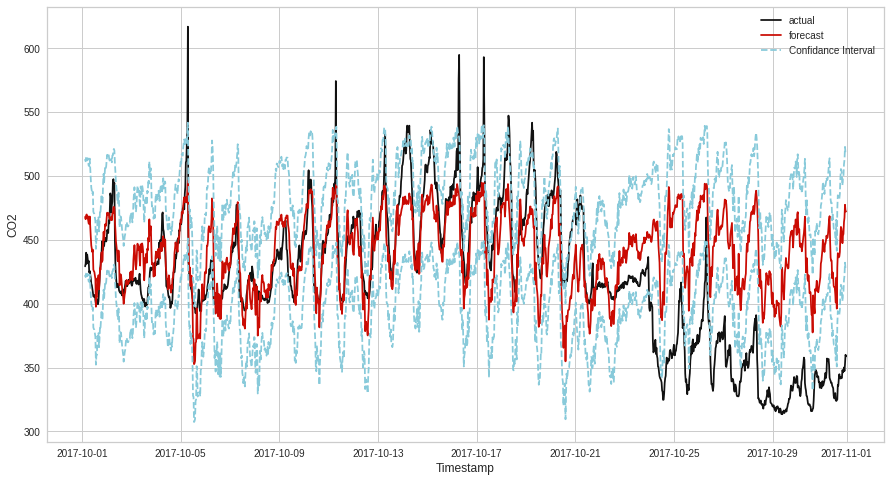

In [77]:
plt.figure(figsize = (15,8))
plt.plot(y_act,c='k')
plt.plot(y_for, c='r')
plt.plot(y_for + 1.96*conf_inter,'--', c ='c')
plt.plot(y_for - 1.96*conf_inter,'--', c ='c')
plt.xlabel('Timestamp', fontsize = 12)
plt.ylabel('CO2', fontsize = 12)
plt.legend(labels=["actual", "forecast","Confidance Interval"])
plt.show()

Here we can see that more enformations from other sensors can better predict the actual signal. And we can easily compensate the data on a sensor if it drifts from the overall data given by the other sensors.

f) **5/35** Redo the question e) with [statsmodels](https://www.statsmodels.org/stable/index.html), a moudle for statistical models with an extensive list of result statistics. Build the linear regression model with statsmodels and examine the result statistics; keep features whose p-value are strictly less than 0.05 and build a new model. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the new model for the entire month of October. Discuss your findings.

__Note__: This introduciton page of [Linear Regression](https://www.statsmodels.org/stable/regression.html) may be helpful to you.

In [ ]:
def forecast_low_p(model,X, low_p,n,delay=6,mode=0):
    X_tmp = X.copy()
    y_forecast = []
    if mode == 0:
        y_tmp = X_tmp[:,0][delay]
    for i in range(X_tmp.shape[0]-delay):
        if mode == 0:
            X_tmp[:,0][i+delay] = y_tmp
        
        X_pred = X_tmp[i:i+delay+mode].reshape(-1)[low_p[1:]]
        X_pred = np.insert(X_pred, 0, 1)
        X_pred = (X_pred.reshape(1,np.sum(low_p)))
        y_tmp = model.get_prediction(X_pred).se_mean
        y_forecast.append(y_tmp)
    return y_forecast

In [ ]:
def linear_stats(X,features,delay=6,limit_date="2017-10-21", mode = 0):
    
    n = len(features)
    
    train_index = np.array(list(range(len(X[(X["Timestamp"] < limit_date)][:-delay]))))
    X_train = np.zeros([len(train_index),n*(delay+mode)])
    for i in train_index:
        X_train[i] = X[features][i:i+delay+mode].values.reshape(-1)
    y_train = X['CO2'][train_index+delay].values
    X_train = sm.add_constant(X_train)
    results = sm.OLS(y_train, X_train).fit()
    print(np.array(results.pvalues) < 0.05)
    
    low_p = np.array(results.pvalues) < 0.05
    
    X_train = np.zeros([len(train_index),np.sum(low_p[1:])])
    for i in train_index:
        X_train[i] = (X[features][i:i+delay+mode].values.reshape(-1))[low_p[1:]]
    X_train = sm.add_constant(X_train)
    results = sm.OLS(y_train, X_train).fit()
    
    y_forecast = forecast_low_p(results, X[features].values, low_p,len(features),delay=delay,mode=mode)
    y_actual = X['CO2'][delay:]
    
    time = X['Timestamp'][delay:].drop_duplicates()
        
    return model, np.array(y_forecast).flatten() , y_actual, time, low_p
    
model, y_forecast , y_actual, time, low_p = linear_stats(X_features.reset_index(),list(X_features.columns[1:]),mode=1)

fig = plt.figure(figsize = (15,8))
print(y_forecast.shape)
print(y_forecast)
plt.plot(y_actual)
plt.plot(y_forecast)
plt.show()


g) **10/35** In this question, we will use __Bayesian Structural Time Serie Modelling__ to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 21.  We will use the information of provided by similar sensors (the ones you identified in the previous question), together with the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.


Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?

In [60]:
features = curated_data[curated_data['LocationName'] == 'ZSBN'][['humidity', 'temperature']]
targets = curated_data[curated_data['LocationName'] == 'ZSBN'][['CO2']]

for location in closest_regions:
    #     We checked before hand that the whole data (from october 1st to 31st)
    if (location != 'ZPFW'):
        data_tomerge = curated_data[curated_data['LocationName'] == location][['CO2']]
        features = pd.merge(features, data_tomerge, left_index = True, right_index = True)
        
features.index = pd.to_datetime(features.index)
features.head()

,humidity,temperature,CO2_x,CO2_y,CO2_x,CO2_y
Timestamp,,,,,,
2017-10-01 00:00:00,92.608017,11.146667,410.988983,418.430031,419.172551,409.986208
2017-10-01 00:30:00,92.220825,10.915000,412.826743,419.349823,422.965613,411.959539
2017-10-01 01:00:00,92.662059,10.860000,413.304853,419.286677,421.486211,413.270622
2017-10-01 01:30:00,92.934809,10.820000,415.102117,418.800550,416.887221,411.528196
2017-10-01 02:00:00,93.407832,10.760000,415.913092,421.304153,418.834719,415.458255


In [61]:
columns = ['x' + str(i) for i in range(len(features.columns))]
features.columns = columns
features.insert(loc=0, column='y', value=targets['CO2'].values)

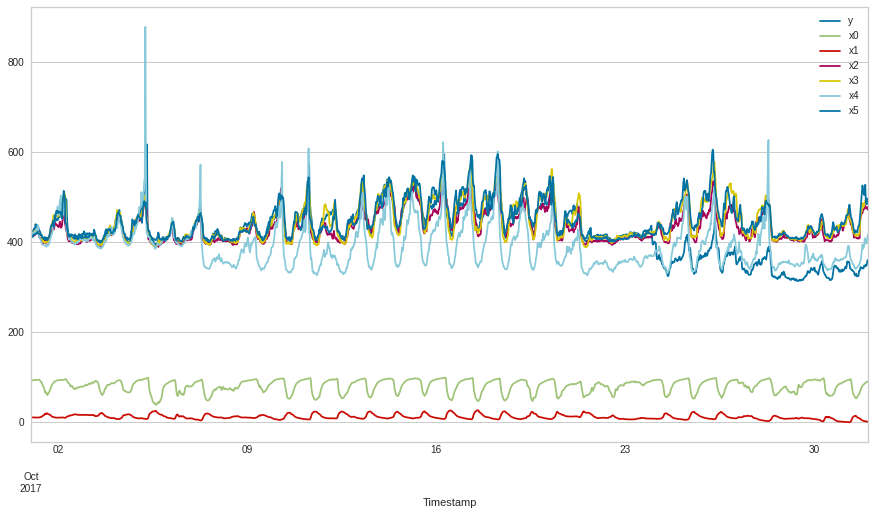

In [62]:
features.plot(figsize=(15,8))

In [63]:
from causalimpact import CausalImpact

pre_drift= ['2017-10-01 00:00:00', '2017-10-23 23:30:00']
post_drift = ['2017-10-24 00:00:00', '2017-10-31 23:30:00']

ci = CausalImpact(features, pre_drift, post_drift)

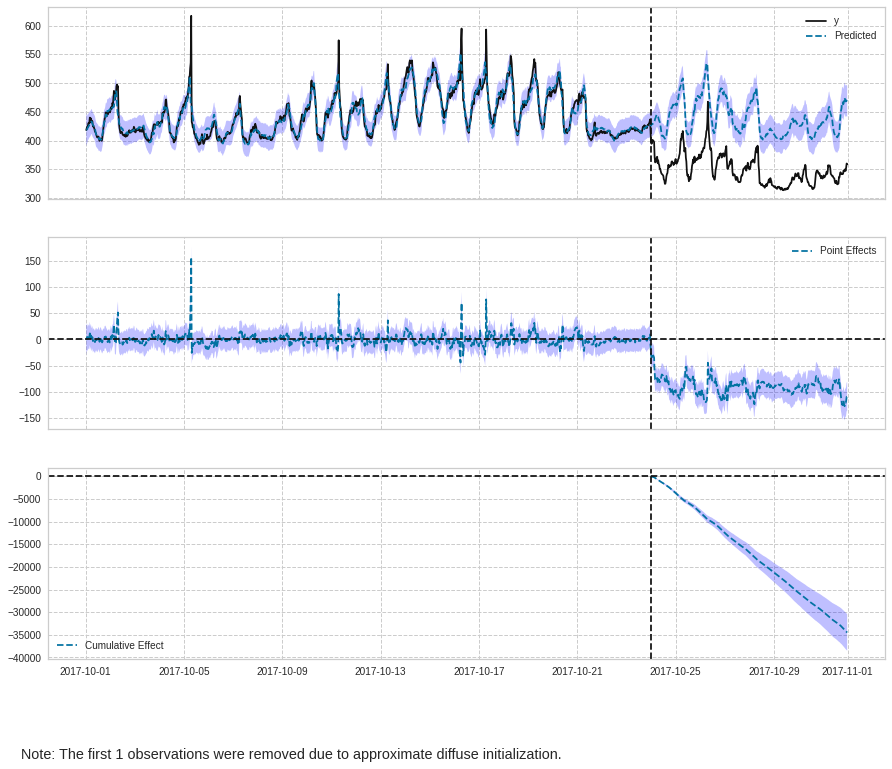

In [64]:
ci.plot()

**Yes, the counterfactual reconstruction of CO2 measurements is significantly different from the observed measurements. This helps us recovering the measurements in the case where the sensor drifts and starts giving false measurements**

In [65]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    349.47             134197.67
Prediction (s.d.)         439.33 (5.39)      168701.14 (2069.63)
95% CI                    [428.66, 449.79]   [164604.95, 172717.74]

Absolute effect (s.d.)    -89.85 (5.39)      -34503.47 (2069.63)
95% CI                    [-100.31, -79.19]  [-38520.07, -30407.28]

Relative effect (s.d.)    -20.45% (1.23%)    -20.45% (1.23%)
95% CI                    [-22.83%, -18.02%] [-22.83%, -18.02%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [66]:
ci.trained_model.params

sigma2.irregular    0.081807
sigma2.level        0.000144
beta.x0             0.198438
beta.x1             0.081051
beta.x2             0.123500
beta.x3             0.474275
beta.x4             0.101588
beta.x5             0.130771
dtype: float64

h) **Bonus (5):** Remove the drift with an advanced machine learning model of your choice. Discuss the results. 